In [1]:
import pandas as pd
import yfinance as yf
import investpy
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def wrangle(list_yf,start_date,end_date, country_list,keywords ):
    
    # Fetching Niftybees and relevant data
    niftybees = yf.download(tickers=list_yf, start=start_date, end=end_date)['Adj Close']

    #Average of daily data to get monthly data
    niftybees = niftybees.groupby([niftybees.index.year, niftybees.index.month]).mean()

    #change index names
    niftybees.index.set_names(['Year','Month'], inplace=True)

    # niftybees to flattern index data
    niftybees = niftybees.reset_index()

    #reset index data to date
    niftybees.index = pd.to_datetime(niftybees.Year.astype(str)+'-'+ niftybees.Month.astype(str)+'-01')

    #get selected variables
    niftybees = niftybees[['CL=F', 'INR=X', 'NIFTYBEES.NS', '^GSPC']]    
    
    # Fetching other exogenous variables from investing.com
    cpi_data_0 = investpy.economic_calendar(countries=country_list, from_date=pd.to_datetime(start_date, format='%Y-%m-%d').strftime('%d/%m/%Y'), to_date=pd.to_datetime(end_date, format='%Y-%m-%d').strftime('%d/%m/%Y'))
    
    # Filter rows where 'event' contains 'Consumer Price Index' or related terms to get inflation data    
    # Create a filter condition
    condition = cpi_data_0['event'].str.contains('|'.join(keywords), case=False, na=False)
    
    # Apply the filter
    cpi_data = cpi_data_0[condition]

    #Selected variables from cpi data
    cpi_data = cpi_data[["date","event","actual"]]

    #change date variable to appropriate format required to concat with yahoo finance data
    cpi_data["date"] = pd.to_datetime(pd.to_datetime(cpi_data["date"], format='%d/%m/%Y').dt.strftime('%Y-%m-01'))

    #set date as index
    cpi_data = cpi_data.set_index(["date"])

    #concatenate both teh investing.com and yahoo finance data
    df = pd.concat([niftybees, cpi_data],axis=1)

    #chnage column names
    df.columns = ['Crude_oil', 'Exchange_rate', 'NIFTYBEES', 'S&P_500', 'CPI_event', 'CPI_actual_growth']
    
    return df

In [3]:
list_yf = ["NIFTYBEES.NS","INR=X", "^GSPC", "CL=F"] # list of data need to be extracted from yahoo finance
start_date = dt.date.today() - dt.timedelta(days=365*10) # start date
end_date = dt.date.today() # End date
#data_interval = '1mo' #days interval between data currently 1 month has chosen
country_list = ['India'] #country for data to be extracted from investpy Economic calander
keywords = ['Consumer Price Index', 'CPI']

df = wrangle(list_yf,start_date,end_date, country_list,keywords)
df.info()

[*********************100%%**********************]  4 of 4 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2014-09-01 to 2024-08-01
Freq: MS
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Crude_oil          120 non-null    float64
 1   Exchange_rate      120 non-null    float64
 2   NIFTYBEES          120 non-null    float64
 3   S&P_500            120 non-null    float64
 4   CPI_event          119 non-null    object 
 5   CPI_actual_growth  119 non-null    object 
dtypes: float64(4), object(2)
memory usage: 6.6+ KB


In [4]:
#rows with NA values 
df[df.isna().any(axis=1)]

,Crude_oil,Exchange_rate,NIFTYBEES,S&P_500,CPI_event,CPI_actual_growth
2020-06-01,38.313636,75.830996,107.415,3104.660933,NaN,NaN


In [5]:
#explore values around 1st na value
df[(df.index>='2014-04-01')&(df.index<='2014-10-01')]

,Crude_oil,Exchange_rate,NIFTYBEES,S&P_500,CPI_event,CPI_actual_growth
2014-09-01,92.910526,60.843211,81.486052,1992.355263,CPI (YoY) (Aug),7.80%
2014-10-01,84.339129,61.303391,80.482058,1937.274350,CPI (YoY) (Aug),6.46%


In [6]:
#explore values around 2nd na value
df[(df.index>='2020-04-01')&(df.index<='2020-10-01')]

,Crude_oil,Exchange_rate,NIFTYBEES,S&P_500,CPI_event,CPI_actual_growth
2020-04-01,16.699048,76.501459,96.215555,2761.975226,CPI (YoY) (Mar),5.91%
2020-05-01,28.527500,75.848957,97.626842,2919.608484,CPI (YoY) (Apr),5.84%
2020-06-01,38.313636,75.830996,107.415000,3104.660933,NaN,NaN
2020-07-01,40.765909,75.045921,115.824347,3207.619096,CPI (YoY) (Jun),6.09%
2020-08-01,42.388095,74.747067,120.439524,3391.710019,CPI (YoY) (Jul),6.93%
2020-09-01,39.625714,73.593927,120.923182,3365.516671,CPI (YoY) (Aug),6.69%
2020-10-01,39.554545,73.590524,125.683333,3418.699996,CPI (YoY) (Sep),7.34%


In [7]:
# It doesn't look much difference before and after na values so either we can interpolate or for now just remove na Values 
#but we don't need to remove from this data as our main data is return data so we will remove from that data.


In [8]:
df.dropna(inplace=True)
df

,Crude_oil,Exchange_rate,NIFTYBEES,S&P_500,CPI_event,CPI_actual_growth
2014-09-01,92.910526,60.843211,81.486052,1992.355263,CPI (YoY) (Aug),7.80%
2014-10-01,84.339129,61.303391,80.482058,1937.274350,CPI (YoY) (Aug),6.46%
2014-11-01,75.810001,61.633000,85.150611,2044.572105,CPI (YoY) (Oct),5.52%
2014-12-01,59.289545,62.736348,84.222227,2054.266363,CPI (YoY) (Nov),4.38%
2015-01-01,47.325500,62.203273,86.008763,2028.178510,CPI (YoY) (Dec),5.00%
...,...,...,...,...,...,...
2024-04-01,84.394091,83.409300,248.481001,5112.492742,CPI (YoY) (Mar),4.85%
2024-05-01,78.621364,83.372339,249.429999,5235.225497,CPI (YoY) (Apr),4.83%
2024-06-01,78.698421,83.483200,259.927371,5415.140497,CPI (YoY) (May),4.75%
2024-07-01,80.481364,83.582601,272.526367,5538.004572,CPI (YoY) (Jun),5.08%


In [9]:
df_num = df[['Crude_oil', 'Exchange_rate', 'NIFTYBEES', 'S&P_500','CPI_actual_growth']]
df_num

,Crude_oil,Exchange_rate,NIFTYBEES,S&P_500,CPI_actual_growth
2014-09-01,92.910526,60.843211,81.486052,1992.355263,7.80%
2014-10-01,84.339129,61.303391,80.482058,1937.274350,6.46%
2014-11-01,75.810001,61.633000,85.150611,2044.572105,5.52%
2014-12-01,59.289545,62.736348,84.222227,2054.266363,4.38%
2015-01-01,47.325500,62.203273,86.008763,2028.178510,5.00%
...,...,...,...,...,...
2024-04-01,84.394091,83.409300,248.481001,5112.492742,4.85%
2024-05-01,78.621364,83.372339,249.429999,5235.225497,4.83%
2024-06-01,78.698421,83.483200,259.927371,5415.140497,4.75%
2024-07-01,80.481364,83.582601,272.526367,5538.004572,5.08%


In [10]:
df_num = df_num.apply(lambda x: x.str.replace('%','').astype(float) if x.dtype =='O' else x)
df_num

,Crude_oil,Exchange_rate,NIFTYBEES,S&P_500,CPI_actual_growth
2014-09-01,92.910526,60.843211,81.486052,1992.355263,7.80
2014-10-01,84.339129,61.303391,80.482058,1937.274350,6.46
2014-11-01,75.810001,61.633000,85.150611,2044.572105,5.52
2014-12-01,59.289545,62.736348,84.222227,2054.266363,4.38
2015-01-01,47.325500,62.203273,86.008763,2028.178510,5.00
...,...,...,...,...,...
2024-04-01,84.394091,83.409300,248.481001,5112.492742,4.85
2024-05-01,78.621364,83.372339,249.429999,5235.225497,4.83
2024-06-01,78.698421,83.483200,259.927371,5415.140497,4.75
2024-07-01,80.481364,83.582601,272.526367,5538.004572,5.08


In [11]:


def return_data(data):
    df_return = data[['Crude_oil', 'Exchange_rate', 'NIFTYBEES', 'S&P_500']].pct_change()*100
    df_return = pd.concat([df_return, data['CPI_actual_growth']], axis=1).dropna().round(2)
    
    return df_return

In [12]:
df_return = return_data(df_num)
df_return

,Crude_oil,Exchange_rate,NIFTYBEES,S&P_500,CPI_actual_growth
2014-10-01,-9.23,0.76,-1.23,-2.76,6.46
2014-11-01,-10.11,0.54,5.80,5.54,5.52
2014-12-01,-21.79,1.79,-1.09,0.47,4.38
2015-01-01,-20.18,-0.85,2.12,-1.27,5.00
2015-02-01,7.18,-0.27,2.75,2.66,5.11
...,...,...,...,...,...
2024-04-01,4.96,0.47,1.22,-1.12,4.85
2024-05-01,-6.84,-0.04,0.38,2.40,4.83
2024-06-01,0.10,0.13,4.21,3.44,4.75
2024-07-01,2.27,0.12,4.85,2.27,5.08


In [13]:
# Functions to calculate correlation coefficient between two arrays

def corr(x, y, **kwargs):
    # Calculate the value
    corr_coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r"$\rho$ = " + str(round(corr_coef, 2))

    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy=(0.3, 0.15), size=20, xycoords=ax.transAxes)



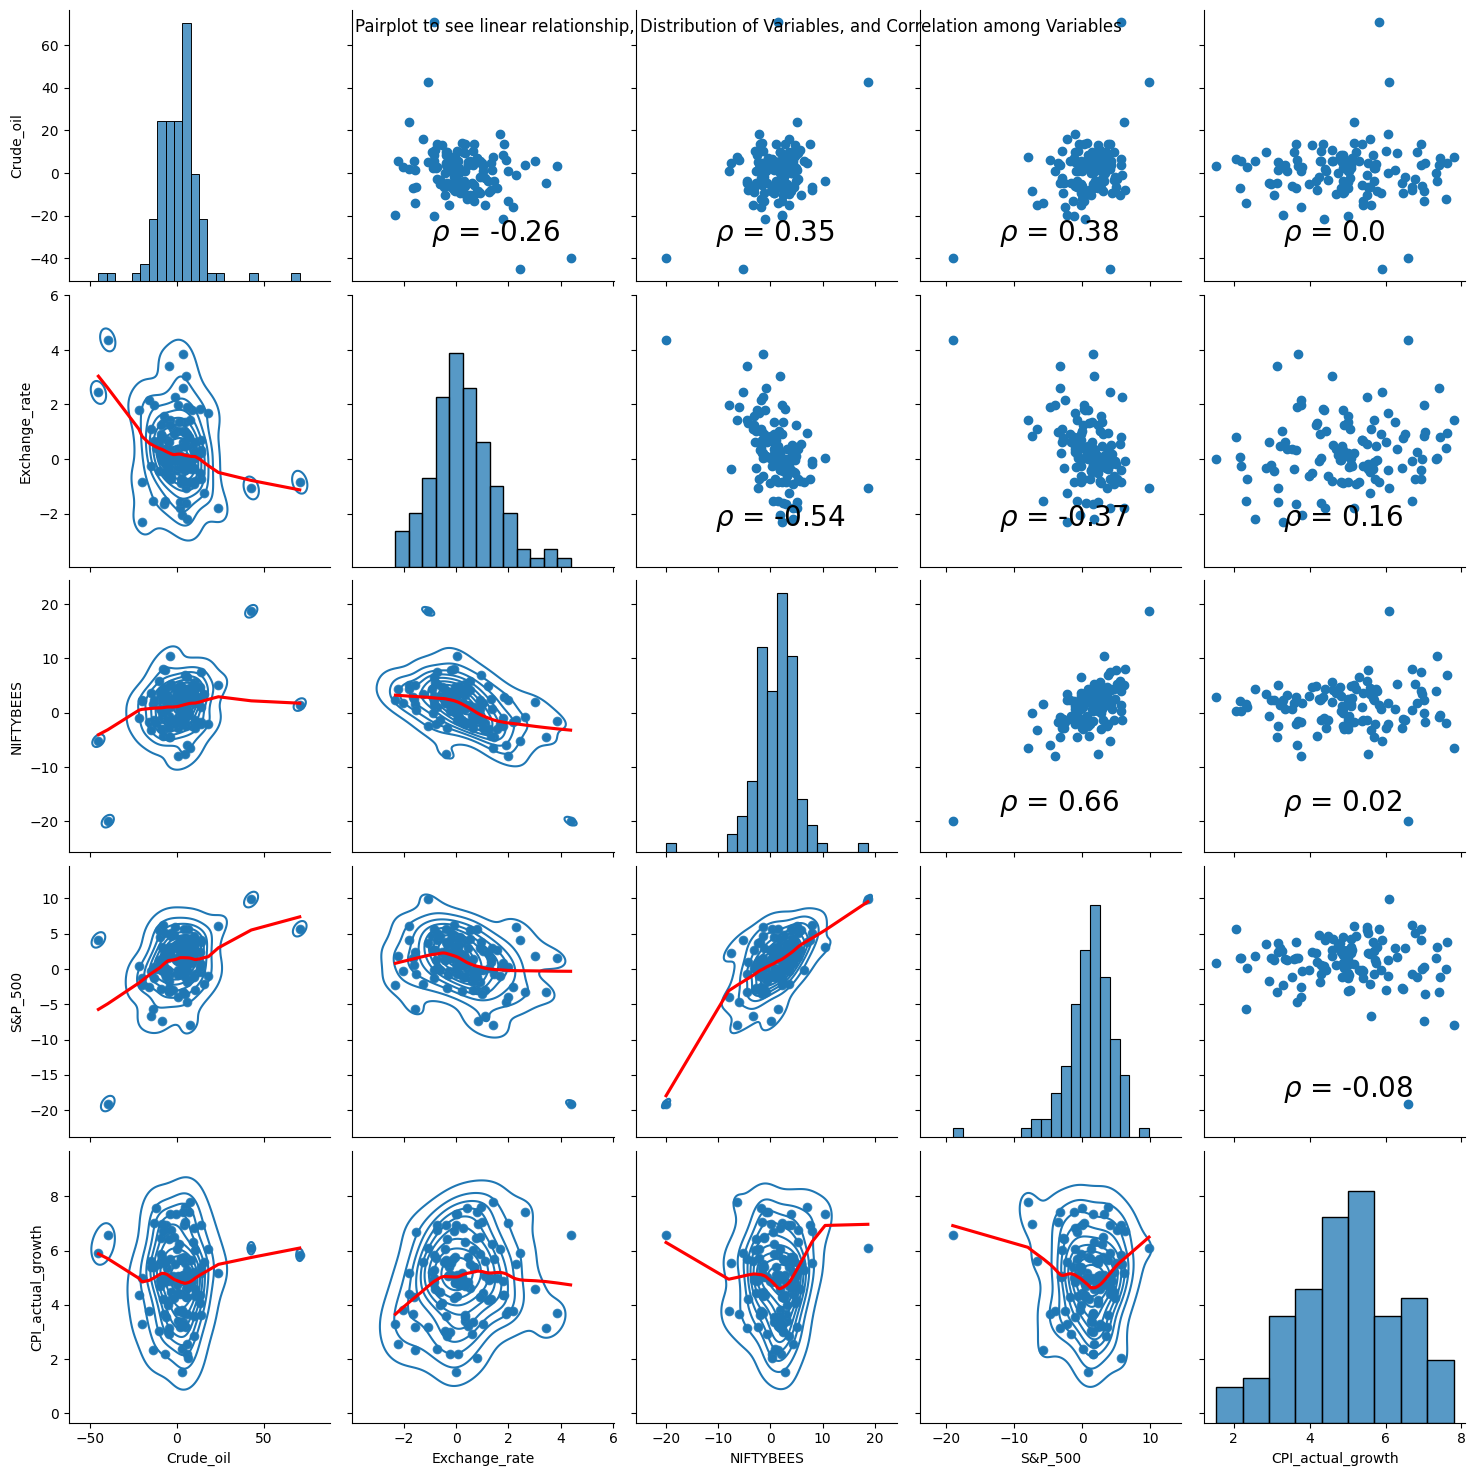

In [14]:
# Create the default pairplot
pair_plot = sns.pairplot(
    df_return, vars=df_return.columns, height=3
)

# Map a scatter plot and Pearson correlation coefficient to the upper triangle
pair_plot = pair_plot.map_upper(plt.scatter)
pair_plot = pair_plot.map_upper(corr)

# Map a histogram to the diagonal
# grid = grid.map_diag(plt.hist)

# Map a density plot and regression line to the lower triangle
pair_plot = pair_plot.map_lower(sns.kdeplot)
pair_plot = pair_plot.map_lower(sns.regplot, lowess=True, line_kws={"color": "red"})

pair_plot.fig.suptitle("Pairplot to see linear relationship, Distribution of Variables, and Correlation among Variables");


In [15]:
# We need to further check all assumptuions using statistcial method

In [41]:
# df_return.columns[~df_return.columns.isin(["NIFTYBEES"])]

Index(['Crude_oil', 'Exchange_rate', 'S&P_500', 'CPI_actual_growth'], dtype='object')

In [42]:
# OLS regression
X = df_return.drop(columns=["NIFTYBEES"])
y = df_return["NIFTYBEES"]

X=sm.add_constant(X)
model_ols = sm.OLS(
    y,X
).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NIFTYBEES   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     34.24
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           1.06e-18
Time:                        19:32:44   Log-Likelihood:                -289.15
No. Observations:                 118   AIC:                             588.3
Df Residuals:                     113   BIC:                             602.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.8758      0.997     -0.878      0.382      -2.851       1.100
Crude_oil             0.0216      0.023      0.948      0.345      -0.024       0.067
Exchange_rate        -1.2085      0.241     -5.013      0.000      -1.686      -0.731
S&P_500               0.6067      0.085      7.122      0.000       0.438       0.776
CPI_actual_growth     0.3544      0.193      1.833      0.069      -0.029       0.737
==============================================================================
Omnibus:                        8.005   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.018   Jarque-Bera (JB):               11.947
Skew:                          -0.292   Prob(JB):                      0.00255
Kurtosis:                       4.446   Cond. No.                         49.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

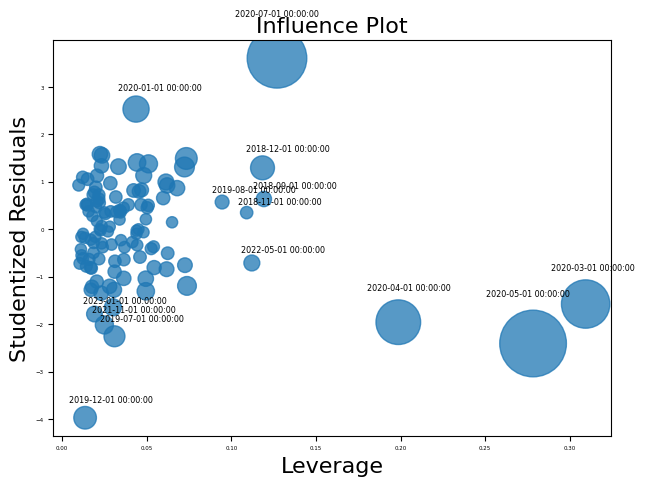

In [58]:
plt.rcParams.update({'font.size':4})
fig = sm.graphics.influence_plot(model_ols, criterion="cooks",alpha=0.1)

fig.tight_layout()

In [62]:
influence_points = model_ols.get_influence()
influence_points.summary_frame().sort_values("cooks_d",ascending=False)

,dfb_const,dfb_Crude_oil,dfb_Exchange_rate,dfb_S&P_500,dfb_CPI_actual_growth,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
2020-05-01,0.072300,-1.408940,-0.065732,0.163907,-0.135028,4.296160e-01,-2.360154,0.278306,-1.465633,-2.409834,-1.496484
2020-07-01,-0.272521,0.895055,0.022612,0.502277,0.324207,3.406606e-01,3.422251,0.126969,1.305107,3.598665,1.372384
2020-03-01,0.002023,0.169993,-0.198682,0.736757,-0.098973,2.202589e-01,-1.567966,0.309369,-1.049426,-1.578276,-1.056326
2020-04-01,0.131834,0.809927,-0.319072,-0.580793,-0.133840,1.859672e-01,-1.936661,0.198662,-0.964280,-1.960890,-0.976344
2020-01-01,-0.364395,-0.175720,-0.073530,0.204404,0.434199,5.575652e-02,2.470666,0.043676,0.527999,2.528965,0.540457
...,...,...,...,...,...,...,...,...,...,...,...
2019-09-01,-0.006577,-0.000810,-0.002701,-0.002534,0.005973,1.350801e-05,-0.049272,0.027067,-0.008218,-0.049055,-0.008182
2022-06-01,0.002781,-0.002391,-0.000217,0.003767,-0.003950,9.076158e-06,-0.031397,0.044010,-0.006737,-0.031258,-0.006707
2017-11-01,-0.003325,-0.001909,0.000779,0.000823,0.002615,3.920845e-06,-0.029046,0.022710,-0.004428,-0.028917,-0.004408
2017-08-01,-0.000663,-0.000080,0.000217,0.000215,0.000569,1.066854e-07,-0.003360,0.045117,-0.000730,-0.003345,-0.000727


In [ ]:
# bigger the circle in influence plot shows influencial points that affects the regression
#these influencial points are mainly occured in COVID period.